## A Mathematical Approach to Map Matching Algorithms

### A project sponsered by Mitsubishi and supported by Tohoku University in Sendai, Japan

Team: Seiya Omura, Tomoya Akamatsu, Katelynn Huneycutt, Gabriel Gress


In [1]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon, Point
import os, io, sys
import numpy as np
import ujson as json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils
import fiona

# Remove this when debugging
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
ox.__version__

if not os.path.exists("temp/"):
    os.makedirs("temp/")


/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


'1.2.1'

### How do we represent road networks and GPS sequences computationally?

First, we download from OpenStreetMaps a street map for a section of Sendai, JP-- particularly, the area around Tohoku University. However, OSMnx by default does not track directionality of roads-- this is an important factor when map matching, so we use a script created by cyang-kth for their fmm program which saves this information.

<AxesSubplot:>

<AxesSubplot:>

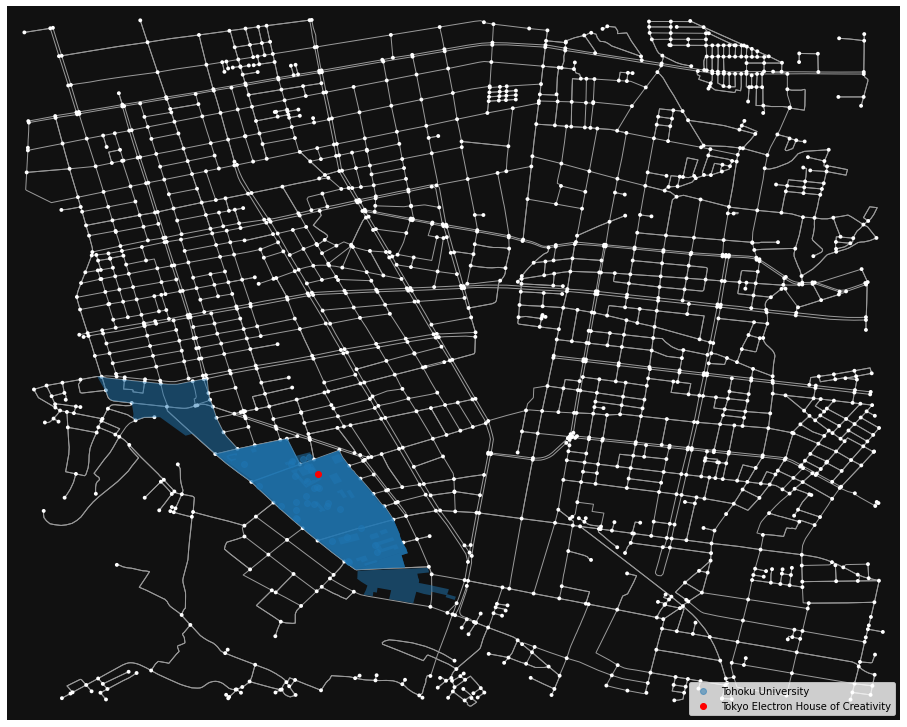

In [2]:
bignetwork = ox.graph_from_address(
"Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",
dist=1750, network_type='drive')

fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False,close=False)

campus = ox.geometries.geometries_from_place('Katahira Campus ',tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)

gpd.GeoSeries([Point((140.87387,38.25448))]).plot(ax=ax, color='red')

ax.legend(handles=[ax.collections[4],ax.collections[5]],
          labels=['Tohoku University', 'Tokyo Electron House of Creativity'],
          loc = 'lower right')

The default format that OSMnx models networks is as `MultiDiGraph` objects. In order to manipulate these objects geometrically, we will need to convert this to `GeoDataFrame`. 

In [3]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(bignetwork)
#gdf_edges.dtypes
gdf_edges = gdf_edges.reset_index([0,1,2])
gdf_edges = gdf_edges.set_index('osmid')
gdf_nodes[['geometry']].head()

,geometry
osmid,
244879417,POINT (140.87168 38.26613)
244879418,POINT (140.87520 38.26010)
301789611,POINT (140.87349 38.25607)
301789618,POINT (140.87595 38.25510)
301789634,POINT (140.87949 38.25282)


In [4]:
gdf_edges[[ 'oneway', 'name', 'maxspeed', 'length', 'geometry']].head()

,oneway,name,maxspeed,length,geometry
osmid,,,,,
218028552,True,定禅寺通,60,17.586,"LINESTRING (140.87168 38.26613, 140.87148 38.2..."
461330966,True,東二番丁通,60,66.732,"LINESTRING (140.87168 38.26613, 140.87178 38.2..."
30999231,True,青葉通,NaN,15.304,"LINESTRING (140.87520 38.26010, 140.87503 38.2..."
899682371,True,東二番丁通,60,94.102,"LINESTRING (140.87520 38.26010, 140.87564 38.2..."
837910375,False,NaN,NaN,11.727,"LINESTRING (140.87349 38.25607, 140.87347 38.2..."


Now let's look at the GPS data from a day walking around Sendai.

In [5]:
# Enable KML driver
fiona.drvsupport.supported_drivers["KML"] = "rw"

# Read file from KML
#fp = "history-2022-06-21.kml"
fp = "7-13-22.geojson"
with open(fp) as f:
    data = json.load(f)
    tripdata_nodes = gpd.GeoDataFrame.from_features(data)
tripdata_nodes = tripdata_nodes.sort_values(by='timestamp').reset_index(drop=True)
tripdata_edges = mm_utils.point_to_traj(tripdata_nodes)

<AxesSubplot:>

<AxesSubplot:>

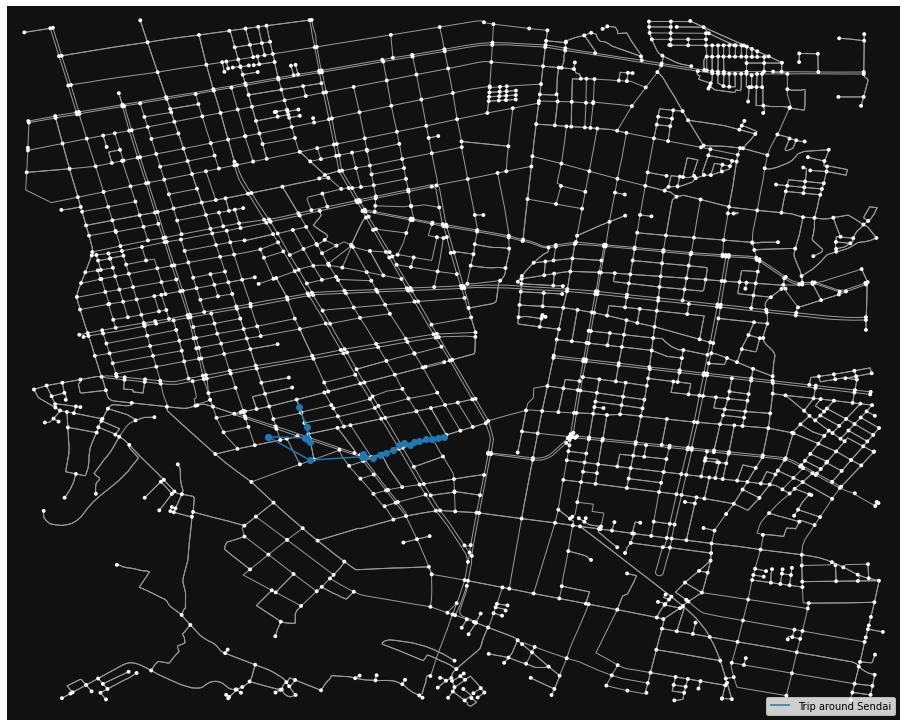

In [6]:
fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False, close=False)
tripdata_nodes.plot(ax=ax)
tripdata_edges.plot(ax=ax)
ax.legend(handles=[ax.collections[3]],labels=['Trip around Sendai'], loc = 'lower right')

Let's zoom in a bit.

<AxesSubplot:>

<AxesSubplot:>

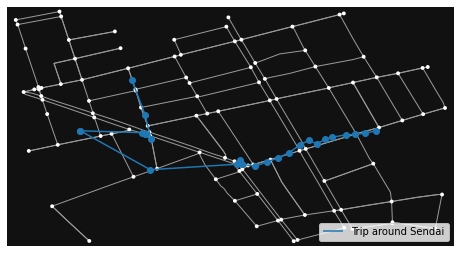

In [7]:
smallnetwork = mm_utils.df_to_network(tripdata_nodes, as_gdf = False)
fig, ax = ox.plot_graph(smallnetwork, figsize=(8,8), show=False, close=False)
tripdata_nodes.plot(ax=ax)
tripdata_edges.plot(ax=ax)
ax.legend(handles=[ax.collections[3]],labels=['Trip around Sendai'], loc = 'lower right')

Now we will run this information through FMM.

In [8]:
from algorithms import fmm_bin
from fmm import FastMapMatchConfig
### Define map matching configurations

k = 8
radius = 0.003
gps_error = 0.0005

# create a text trap and redirect stdout
#text_trap = io.StringIO()
#sys.stdout = text_trap

fmm_config = FastMapMatchConfig(k,radius,gps_error)
cfg_file = None



fmm_sim = fmm_bin.FMM(cfg = fmm_config)

fmm_sim.run(tripdata_edges)

# now restore stdout function
#sys.stdout = sys.__stdout__

/home/gjgress/G-RIPS-2022-Mitsubishi-A/Code/algorithms/fmm_bin.py:50: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


[2022-07-15 01:12:42.821] [info] [network.cpp:72] Read network from file temp/network_edges.shp
[2022-07-15 01:12:42.830] [info] [network.cpp:170] Number of edges 218 nodes 104
[2022-07-15 01:12:42.830] [info] [network.cpp:171] Field index: id 12 source 0 target 1
[2022-07-15 01:12:42.830] [info] [network.cpp:174] Read network done.
[2022-07-15 01:12:42.875] [info] [network_graph.cpp:17] Construct graph from network edges start
[2022-07-15 01:12:42.875] [info] [network_graph.cpp:30] Graph nodes 104 edges 218
[2022-07-15 01:12:42.875] [info] [network_graph.cpp:31] Construct graph from network edges end
[2022-07-15 01:12:42.875] [info] [ubodt_gen_algorithm.cpp:76] Start to generate UBODT with delta 0.02
[2022-07-15 01:12:42.875] [info] [ubodt_gen_algorithm.cpp:77] Output format csv
[2022-07-15 01:12:42.881] [info] [ubodt_gen_algorithm.cpp:105] Progress 10 / 104
[2022-07-15 01:12:42.882] [info] [ubodt_gen_algorithm.cpp:105] Progress 20 / 104
[2022-07-15 01:12:42.883] [info] [ubodt_gen_alg

In [13]:
fmm_sim.results[['index', 'osmid', 'geometry']].head()

,index,osmid,geometry
0,0,837910375,"LINESTRING (140.87349 38.25607, 140.87347 38.2..."
1,1,"[837910369, 837910371]","LINESTRING (140.87349 38.25607, 140.87335 38.2..."
2,4,32896012,"LINESTRING (140.87595 38.25510, 140.87576 38.2..."
3,11,153276508,"LINESTRING (140.87697 38.25709, 140.87702 38.2..."
4,13,837910348,"LINESTRING (140.87916 38.25612, 140.87909 38.2..."


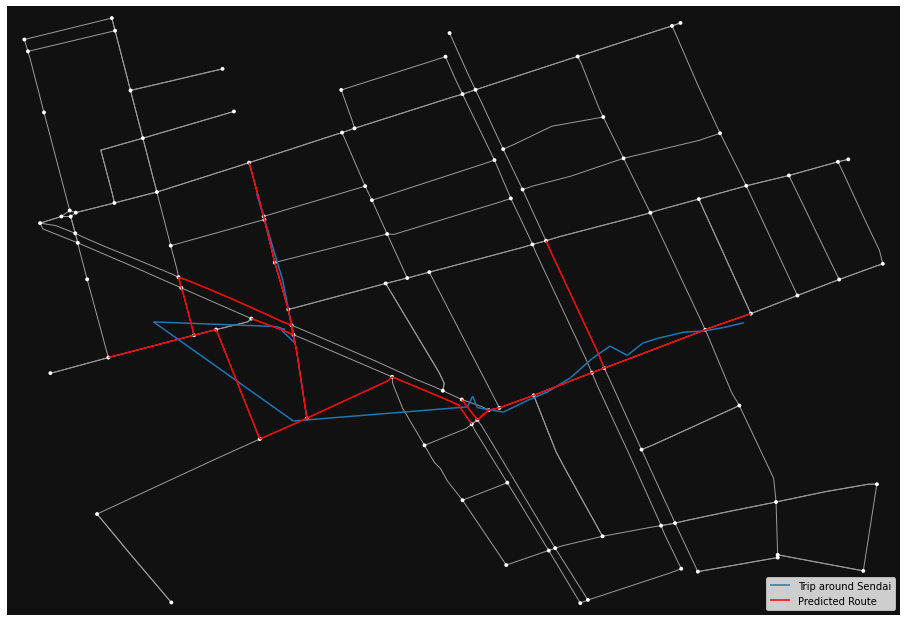

In [11]:
mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = fmm_sim.results, fs = (16,16))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','Predicted Route'], loc = 'lower right')

In [12]:
!rm -r temp